In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import featuretools as ft
from sklearn.metrics import make_scorer, mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from pathlib import Path
import config

sys.path.append('./starspace36_mono_model')
# import starspace_resources as sw_resources

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (20, 15)

print(Path.cwd())

/home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/home_works/1. Auto_ML/drivendata_flu_shot


In [2]:
X = pd.read_csv("./input/training_set_features.csv", index_col='respondent_id')
y = pd.read_csv("./input/training_set_labels.csv", index_col='respondent_id')
submission_format = pd.read_csv("./input/submission_format.csv", index_col='respondent_id')
test_set = pd.read_csv("./input/test_set_features.csv", index_col='respondent_id')

# X = pd.read_csv("./input/training_set_features.csv")
# y = pd.read_csv("./input/training_set_labels.csv")
# submission_format = pd.read_csv("./input/submission_format.csv")
# test_set = pd.read_csv("./input/test_set_features.csv")

X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:
X['test'] = False
test_set['test'] = True

X.reset_index(inplace=True, )
test_set.reset_index(inplace=True, )
X_joined = X.append(test_set, ignore_index=True, sort=False)

In [4]:
# split for ordinal values manually, i.e. ages groups
X_joined.replace(to_replace=config.ordinal_to_replace, inplace=True)

numeric = []
for col in config.ordinal:
    num_col = f'{col}_num'
    numeric.append(num_col)
    X_joined[num_col] = X_joined[col]

In [5]:
# Add dataframe to entityset
categorical_ft = dict([col, ft.variable_types.Boolean] for col in config.categorical.keys())
ordinal_ft = dict([col, ft.variable_types.Ordinal] for col in config.ordinal)
numeric_ft = dict([col, ft.variable_types.Numeric] for col in numeric)
variable_dtypes = {**categorical_ft, **ordinal_ft, **numeric_ft}

In [6]:
# Create an entity set
es = ft.EntitySet(id='flu')
es = es.entity_from_dataframe(entity_id='flu',
                              dataframe=X_joined,
                              index='respondent_id',
                              variable_types=variable_dtypes,
                              )

In [7]:
es['flu']

Entity: flu
  Variables:
    respondent_id (dtype: index)
    test (dtype: boolean)
    behavioral_antiviral_meds (dtype: boolean)
    behavioral_avoidance (dtype: boolean)
    behavioral_face_mask (dtype: boolean)
    behavioral_wash_hands (dtype: boolean)
    behavioral_large_gatherings (dtype: boolean)
    behavioral_outside_home (dtype: boolean)
    behavioral_touch_face (dtype: boolean)
    doctor_recc_h1n1 (dtype: boolean)
    doctor_recc_seasonal (dtype: boolean)
    chronic_med_condition (dtype: boolean)
    child_under_6_months (dtype: boolean)
    health_worker (dtype: boolean)
    health_insurance (dtype: boolean)
    race (dtype: boolean)
    sex (dtype: boolean)
    marital_status (dtype: boolean)
    rent_or_own (dtype: boolean)
    employment_status (dtype: boolean)
    hhs_geo_region (dtype: boolean)
    census_msa (dtype: boolean)
    employment_industry (dtype: boolean)
    employment_occupation (dtype: boolean)
    h1n1_concern (dtype: ordinal)
    h1n1_knowledge (dt

In [8]:
ft.list_primitives()

,name,type,dask_compatible,koalas_compatible,description
0,max,aggregation,True,True,"Calculates the highest value, ignoring `NaN` v..."
1,mode,aggregation,False,False,Determines the most commonly repeated value.
2,all,aggregation,True,False,Calculates if all values are 'True' in a list.
3,entropy,aggregation,False,False,Calculates the entropy for a categorical variable
4,last,aggregation,False,False,Determines the last value in a list.
5,std,aggregation,True,True,Computes the dispersion relative to the mean v...
6,median,aggregation,False,False,Determines the middlemost number in a list of ...
7,trend,aggregation,False,False,Calculates the trend of a variable over time.
8,n_most_common,aggregation,False,False,Determines the `n` most common elements.
9,count,aggregation,True,True,"Determines the total number of values, excludi..."


In [9]:
# Define which primitives to use
#agg_primitives =  ['count',]
# trans_primitives = ['cum_sum']

agg_primitives =  ['count', 'mean', 'num_unique']
trans_primitives = ['add_numeric']

In [10]:
# Run deep feature synthesis
dfs_feat, dfs_defs = ft.dfs(entityset=es,
                            target_entity='flu',
                            trans_primitives=trans_primitives,
                            agg_primitives=agg_primitives,
                            max_features=1000,
                            chunk_size=4000,
                            verbose=True,
                            max_depth=2,
                            n_jobs=1)


Built 127 features
Elapsed: 00:00 | Progress: 100%|██████████


/home/sergey/anaconda3/envs/ml_advanced_project/lib/python3.8/site-packages/featuretools/synthesis/dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'mean', 'num_unique']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


In [11]:
dfs_feat.shape

(53415, 127)

In [12]:
h1n1_train_counts = y.h1n1_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов h1n1_train_counts \n")
print(f" {h1n1_train_counts.values} {h1n1_train_counts[1] / h1n1_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов h1n1_train_counts 

 [21033  5674] 0.26976655731469595


In [13]:
seasonal_train_counts = y.seasonal_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов seasonal_train_counts \n")
print(f" {seasonal_train_counts.values} {seasonal_train_counts[1] / seasonal_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов seasonal_train_counts 

 [14272 12435] 0.8712864349775785


In [14]:
test_set = dfs_feat.loc[dfs_feat.test].copy()
test_set.drop(columns=['test'], inplace=True)
test_set = test_set.astype(config.categorical)

In [15]:
X = dfs_feat.loc[~dfs_feat.test].copy()
X = X.astype(config.categorical)
X.drop(columns=['test'], inplace=True)

In [16]:
X_train, X_val, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [17]:
%%time 
print(y.columns)
models = {}
for col in y.columns:
    print('********* Hyperopt main loop', col, '*****************')
    train_set = Pool(data=X_train, label=y_train[col], cat_features=config.categorical.keys())
    val_set = Pool(data=X_val, label=y_test[col], cat_features=config.categorical.keys())

    clf = CatBoostClassifier(**config.params)
    clf.fit(X=train_set, eval_set=val_set, use_best_model=True)

    models[col] = clf
    

Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')
********* Hyperopt main loop h1n1_vaccine *****************
0:	learn: 0.7536781	test: 0.7478475	best: 0.7478475 (0)	total: 91.6ms	remaining: 30m 32s
1000:	learn: 0.8626600	test: 0.8521350	best: 0.8521350 (1000)	total: 31.1s	remaining: 9m 49s
2000:	learn: 0.8750846	test: 0.8603910	best: 0.8603910 (2000)	total: 1m 4s	remaining: 9m 42s
3000:	learn: 0.8816401	test: 0.8634513	best: 0.8634513 (3000)	total: 1m 40s	remaining: 9m 26s
4000:	learn: 0.8857948	test: 0.8649300	best: 0.8649300 (4000)	total: 2m 14s	remaining: 8m 55s
5000:	learn: 0.8891631	test: 0.8656327	best: 0.8656327 (5000)	total: 2m 46s	remaining: 8m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8657692945
bestIteration = 5388

Shrink model to first 5389 iterations.
********* Hyperopt main loop seasonal_vaccine *****************
0:	learn: 0.8001682	test: 0.7905021	best: 0.7905021 (0)	total: 38.8ms	remaining: 12m 55s
1000:	learn: 0.8559026	test: 

h1n1_vaccine
feature_importance < 0.01
h1n1_knowledge 0.005883829779951767
opinion_h1n1_sick_from_vacc 0.009761954630392847
opinion_seas_vacc_effective 0.006017368970898913
opinion_seas_risk 0.0046698808116485855
income_poverty 0.000185400640622574
household_adults 0.003681014564195066
household_children 0.000651809585664309
h1n1_knowledge_num 0.006683982114159764
opinion_h1n1_sick_from_vacc_num 0.006516571990520755
opinion_seas_vacc_effective_num 0.0038318274971657837
opinion_seas_risk_num 0.002985106979044581
education_num 0.006553112938815714
income_poverty_num 0.0003379961039752911
household_adults_num 0.0024408645849482978
household_children_num 0.0013313420230093458
household_adults_num + household_children_num 0.009478629324160374
household_children_num + income_poverty_num 0.0007767459253845627
seasonal_vaccine
feature_importance < 0.01
household_adults 0.006982936723688918
opinion_h1n1_sick_from_vacc_num 0.006733372756616581
income_poverty_num 0.009106604362691492
household_ad

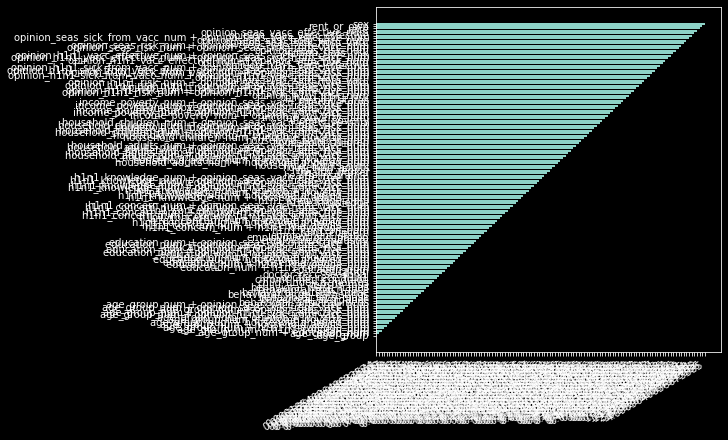

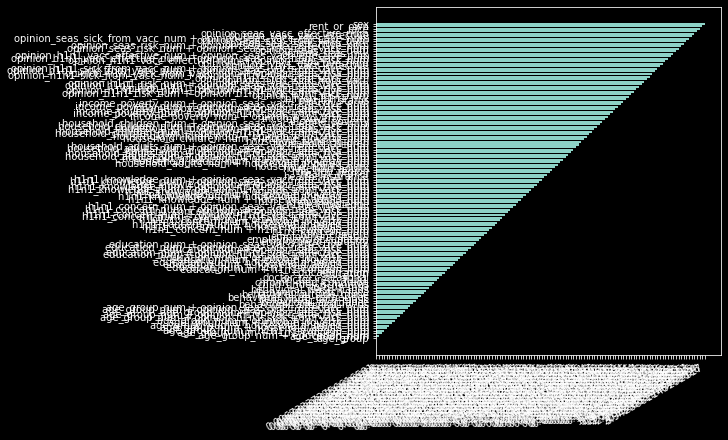

In [18]:
# Графики feature importances

for model_name, model in models.items():
    print(model_name)
    print(model)
    print('feature_importance < 0.01')
    for feature_name, feature_importance in zip(model.feature_names_, model.feature_importances_):
        if feature_importance < 0.01:
            print( feature_name, feature_importance)

    importances_np = np.sort(np.array([model.feature_importances_, model.feature_names_]), axis=1)

    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True);
    ax.barh(importances_np[1], importances_np[0], align='center');
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right");


In [19]:
print("submission")

submission_df = pd.DataFrame(index=test_set.index)
for col, model in models.items():
    test_pool = Pool(test_set, cat_features=config.categorical.keys())

    # predictions_df = pd.DataFrame(index=test_set.index)
    submission_df[col] = model.predict_proba(test_pool)[:, 1]
            

print("submission_df.shape", submission_df.shape)
print(submission_df.head())

submission
submission_df.shape (26708, 2)
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.155244          0.189213
26708              0.043491          0.070152
26709              0.245241          0.775696
26710              0.713349          0.925468
26711              0.419949          0.682499


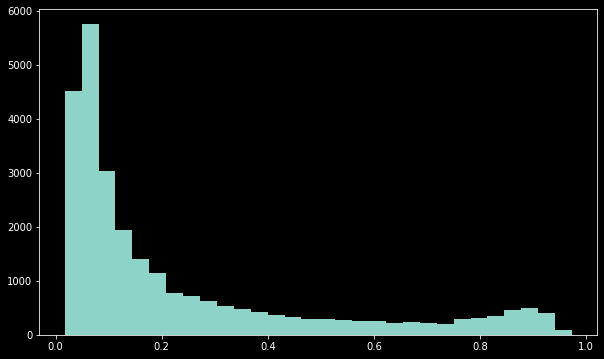

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.h1n1_vaccine, bins=30);

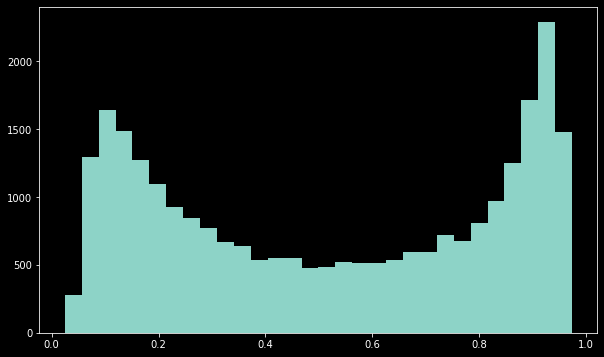

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.seasonal_vaccine, bins=30);

In [22]:
submission_df.head(15)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.155244,0.189213
26708,0.043491,0.070152
26709,0.245241,0.775696
26710,0.713349,0.925468
26711,0.419949,0.682499
26712,0.812423,0.965489
26713,0.271688,0.622862
26714,0.146541,0.177407
26715,0.038755,0.111260


In [23]:
submission_df.to_csv("./flu_submission_noCV.csv")

In [24]:
print('*********   FINISH  ************')






*********   FINISH  ************
